In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import sys
import os

from glob import glob
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets
from PIL import Image

In [60]:
class Conv(nn.Module):
    def __init__(self, out_channels, init_channels=3, input_size=6):
        super(Conv, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Dropout2d(0.3)
            )
        
        self.conv_features = nn.Sequential(
            conv_block(init_channels, 32),
            conv_block(32, 64),
            conv_block(64, 128),
            nn.Conv2d(128, out_channels, kernel_size=1)
        )
        
        self.output_H = input_size // (2 * 2 * 2)
        self.output_W = input_size // (2 * 2 * 2)
    
    def forward(self, x):
        x = self.conv_features(x)
        return x

In [61]:
class MultiFeatureFusion(nn.Module):
    def __init__(self, input_size, embed_dim=256, hidden_dim=512, num_features=1, num_classes=3):
        super(MultiFeatureFusion, self).__init__()

        self.embed_dim = embed_dim
        dim_per_cnn = embed_dim // num_features

        if num_features == 1:
            self.cnn_f1 = Conv(input_size=input_size, out_channels=dim_per_cnn)
            
        elif num_features == 2:
            self.cnn_f1 = Conv(input_size=input_size, out_channels=dim_per_cnn)
            self.cnn_f2 = Conv(input_size=input_size, out_channels=dim_per_cnn)

        else:
            self.cnn_f1 = Conv(input_size=input_size, out_channels=dim_per_cnn)
            self.cnn_f2 = Conv(input_size=input_size, out_channels=dim_per_cnn)
            self.cnn_f3 = Conv(input_size=input_size, out_channels=dim_per_cnn)

        self.f_h = self.cnn_f1.output_H
        self.f_w = self.cnn_f1.output_W
    
        total_in_channels = dim_per_cnn * num_features
        self.fusion_block = nn.Sequential(
            nn.Conv2d(total_in_channels, hidden_dim, kernel_size=1),
            nn.ReLU(),
        )

        final_vec_size = hidden_dim * self.f_h * self.f_w

        self.classifier = nn.Sequential(
            nn.Linear(final_vec_size, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, num_classes)
        )
        
    def forward(self, f_1, f_2=None, f_3=None):
        f_list = []
        if f_2 == None and f_3 == None:
            f1 = self.cnn_f1(f_1)
            f_list.append(f1)

        elif f_2 != None and f_3 == None:            
            f1 = self.cnn_f1(f_1)
            f2 = self.cnn_f2(f_2)
            f_list.append(f1)
            f_list.append(f2)

        else:
            f1 = self.cnn_f1(f_1)
            f2 = self.cnn_f2(f_2)
            f3 = self.cnn_f3(f_3)
            f_list.append(f1)
            f_list.append(f2)
            f_list.append(f3)

        x = torch.cat(f_list, dim=1)
        x = self.fusion_block(x)
        x = x.flatten(start_dim=1)
        
        return self.classifier(x)
    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [62]:
input_size = 24

img1 = torch.randn(6, 3, input_size, input_size)
img2 = torch.randn(6, 3, input_size, input_size)
img3 = torch.randn(6, 3, input_size, input_size)

single_model = MultiFeatureFusion(input_size=input_size, num_features=1)
double_model = MultiFeatureFusion(input_size=input_size, num_features=2)
_multi_model = MultiFeatureFusion(input_size=input_size, num_features=3)

logits = single_model(img1)
print(logits.shape)
print(count_parameters(single_model))

logits = double_model(img1, img2)
print(logits.shape)
print(count_parameters(double_model))

logits = _multi_model(img1, img2, img3)
print(logits.shape)
print(count_parameters(_multi_model))

torch.Size([6, 3])
2619203
torch.Size([6, 3])
2712451
torch.Size([6, 3])
2805058


In [63]:
class NPZdataset(Dataset):
    def __init__(self, npz_path, transform=None):
        self.transform = transform
        data = np.load(npz_path)

        self.gasf_data = data['gasf']
        self.gadf_data = data['gadf']
        self.rp_data = data['rp']
        self.labels = data['labels']

        self.num_samples = len(self.labels)

        print(f"Loaded NPZ Dataset: {self.num_samples} samples.")

    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, index):
        img_gasf = transforms.ToPILImage()(self.gasf_data[index])
        img_gadf = transforms.ToPILImage()(self.gadf_data[index])
        img_rp = transforms.ToPILImage()(self.rp_data[index])
        
        label = self.labels[index]

        if self.transform:
            img_gasf = self.transform(img_gasf)
            img_gadf = self.transform(img_gadf)
            img_rp = self.transform(img_rp)

        return img_gasf, img_gadf, img_rp, torch.tensor(label, dtype=torch.long)

In [71]:
npz_path = 'datasets/FTH/Serialized_FTH_EURUSD.npz'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomErasing()
])

dataset = datasets.ImageFolder(root='datasets/FTH/EURUSD_sample/GASF', transform=transform) # NPZdataset(npz_path, transform)

total_size = len(dataset)
train_size = int(total_size * 0.7)
val_size = int(total_size * 0.15)
test_size = total_size - train_size - val_size

generator = torch.Generator().manual_seed(42)

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size], generator=generator
    )

train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=0
)

val_loader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=0
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=0
)

In [72]:
from torch import nn, optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

epochs = 30

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(single_model.parameters(), lr=1e-4, weight_decay= 1e-5)

train_logs, valid_logs = [], []

single_model.to(device)

MultiFeatureFusion(
  (cnn_f1): Conv(
    (conv_features): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): Dropout2d(p=0.3, inplace=False)
      )
      (1): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): Dropout2d(p=0.3, inplace=False)
      )
      (2): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): Dropout2d(p=0.3, inplace=False)
      )
      (3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (fusion_block): Sequential(
    (0): Conv2d(256, 512, kernel_size

In [73]:
from tqdm import tqdm

for epoch in range(epochs):
    single_model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    progress_bar = tqdm(train_loader, desc=f"Train Epoch [{epoch + 1}/{epochs}]", leave=True)
    
    for images, labels in progress_bar:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = single_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        acc = accuracy_score(all_labels, all_preds)
        prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)

        progress_bar.set_postfix({
            'Loss': f"{loss.item():.4f}",
            'Acc': f"{acc:.4f}",
            'Prec': f"{prec:.4f}",
            'Rec': f"{rec:.4f}"
        })

        avg_loss = running_loss / len(train_loader)
        final_acc = accuracy_score(all_labels, all_preds)
        final_prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        final_rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)

    train_logs.append({
        "Epoch": epoch + 1,
        "Train Loss": running_loss / len(train_loader),
        "Train Accuracy": final_acc,
        "Train Precision": final_prec,
        "Train Recall": final_rec
    })

    print(f"\nEpoch {epoch + 1}, Summary: Loss = {avg_loss:.4f}, Accuracy = {final_acc:.4f}, Precision = {final_prec:.4f}, Recall = {final_rec:.4f}\n", flush=True)

    single_model.eval()
    val_preds, val_labels = [], []
    val_loss = 0.0

    valid_progress_bar = tqdm(val_loader, desc=f"Validation Epoch [{epoch + 1}/epochs]", leave=True)

    with torch.no_grad():
        for image, label in valid_progress_bar:
            image = image.to(device)
            label = label.to(device)

            outputs = single_model(image)
            loss = criterion(outputs, label)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(label.cpu().numpy())

            valid_progress_bar.set_postfix({
                'Loss': f"{loss.item():.4f}",
                'Acc': f"{accuracy_score(val_labels, val_preds):.4f}",
                'Prec': f"{precision_score(val_labels, val_preds, average='macro', zero_division=0):.4f}",
                'Rec': f"{recall_score(val_labels, val_preds, average='macro', zero_division=0):.4f}"
            })

        val_acc = accuracy_score(val_labels, val_preds)
        val_prec = precision_score(val_labels, val_preds, average='macro', zero_division=0)
        val_rec = recall_score(val_labels, val_preds, average='macro', zero_division=0)
        avg_val_loss = val_loss / len(val_loader)
        print(f"✅ Validation Summary: Loss = {avg_val_loss:.4f}, Acc = {val_acc:.4f}, Prec = {val_prec:.4f}, Rec = {val_rec:.4f}\n")
        
        valid_logs.append({
            "Epoch": epoch + 1,
            "Val Loss": val_loss / len(val_loader),
            "Val Accuracy": val_acc,
            "Val Precision": val_prec,
            "Val Recall": val_rec
        })

Train Epoch [1/30]:   0%|          | 0/106 [00:00<?, ?it/s]

Train Epoch [1/30]: 100%|██████████| 106/106 [00:58<00:00,  1.80it/s, Loss=1.0974, Acc=0.3259, Prec=0.3903, Rec=0.3344]


Epoch 1, Summary: Loss = 1.0975, Accuracy = 0.3259, Precision = 0.3903, Recall = 0.3344




Validation Epoch [1/epochs]: 100%|██████████| 23/23 [00:11<00:00,  2.05it/s, Loss=1.0929, Acc=0.3389, Prec=0.3376, Rec=0.3410]


✅ Validation Summary: Loss = 1.0938, Acc = 0.3389, Prec = 0.3376, Rec = 0.3410



Train Epoch [2/30]: 100%|██████████| 106/106 [00:07<00:00, 15.14it/s, Loss=1.0787, Acc=0.3767, Prec=0.3867, Rec=0.3784]


Epoch 2, Summary: Loss = 1.0893, Accuracy = 0.3767, Precision = 0.3867, Recall = 0.3784




Validation Epoch [2/epochs]: 100%|██████████| 23/23 [00:01<00:00, 22.27it/s, Loss=1.1133, Acc=0.3929, Prec=0.4042, Rec=0.3973]


✅ Validation Summary: Loss = 1.0895, Acc = 0.3929, Prec = 0.4042, Rec = 0.3973



Train Epoch [3/30]: 100%|██████████| 106/106 [00:06<00:00, 15.28it/s, Loss=1.0186, Acc=0.3987, Prec=0.3992, Rec=0.3977]


Epoch 3, Summary: Loss = 1.0863, Accuracy = 0.3987, Precision = 0.3992, Recall = 0.3977




Validation Epoch [3/epochs]: 100%|██████████| 23/23 [00:01<00:00, 22.91it/s, Loss=1.1098, Acc=0.3825, Prec=0.3987, Rec=0.3885]


✅ Validation Summary: Loss = 1.0895, Acc = 0.3825, Prec = 0.3987, Rec = 0.3885



Train Epoch [4/30]: 100%|██████████| 106/106 [00:07<00:00, 15.10it/s, Loss=1.0161, Acc=0.3915, Prec=0.3904, Rec=0.3912]


Epoch 4, Summary: Loss = 1.0855, Accuracy = 0.3915, Precision = 0.3904, Recall = 0.3912




Validation Epoch [4/epochs]: 100%|██████████| 23/23 [00:00<00:00, 25.48it/s, Loss=1.1270, Acc=0.3853, Prec=0.4018, Rec=0.3915]


✅ Validation Summary: Loss = 1.0865, Acc = 0.3853, Prec = 0.4018, Rec = 0.3915



Train Epoch [5/30]: 100%|██████████| 106/106 [00:07<00:00, 14.82it/s, Loss=1.0137, Acc=0.4068, Prec=0.4065, Rec=0.4061]


Epoch 5, Summary: Loss = 1.0801, Accuracy = 0.4068, Precision = 0.4065, Recall = 0.4061




Validation Epoch [5/epochs]: 100%|██████████| 23/23 [00:00<00:00, 26.45it/s, Loss=1.1319, Acc=0.3874, Prec=0.4047, Rec=0.3939]


✅ Validation Summary: Loss = 1.0882, Acc = 0.3874, Prec = 0.4047, Rec = 0.3939



Train Epoch [6/30]: 100%|██████████| 106/106 [00:07<00:00, 14.84it/s, Loss=1.0788, Acc=0.3948, Prec=0.3934, Rec=0.3947]


Epoch 6, Summary: Loss = 1.0833, Accuracy = 0.3948, Precision = 0.3934, Recall = 0.3947




Validation Epoch [6/epochs]: 100%|██████████| 23/23 [00:00<00:00, 26.37it/s, Loss=1.0791, Acc=0.3902, Prec=0.4011, Rec=0.3945]


✅ Validation Summary: Loss = 1.0843, Acc = 0.3902, Prec = 0.4011, Rec = 0.3945



Train Epoch [7/30]: 100%|██████████| 106/106 [00:07<00:00, 14.76it/s, Loss=1.1091, Acc=0.4052, Prec=0.4059, Rec=0.4047]


Epoch 7, Summary: Loss = 1.0811, Accuracy = 0.4052, Precision = 0.4059, Recall = 0.4047




Validation Epoch [7/epochs]: 100%|██████████| 23/23 [00:00<00:00, 25.86it/s, Loss=1.0956, Acc=0.3895, Prec=0.4071, Rec=0.3964]


✅ Validation Summary: Loss = 1.0890, Acc = 0.3895, Prec = 0.4071, Rec = 0.3964



Train Epoch [8/30]: 100%|██████████| 106/106 [00:06<00:00, 15.57it/s, Loss=0.9806, Acc=0.4077, Prec=0.4080, Rec=0.4076]


Epoch 8, Summary: Loss = 1.0768, Accuracy = 0.4077, Precision = 0.4080, Recall = 0.4076




Validation Epoch [8/epochs]: 100%|██████████| 23/23 [00:01<00:00, 21.00it/s, Loss=1.1335, Acc=0.4096, Prec=0.4189, Rec=0.4142]


✅ Validation Summary: Loss = 1.0842, Acc = 0.4096, Prec = 0.4189, Rec = 0.4142



Train Epoch [9/30]: 100%|██████████| 106/106 [00:07<00:00, 14.62it/s, Loss=1.1261, Acc=0.4094, Prec=0.4093, Rec=0.4088]


Epoch 9, Summary: Loss = 1.0782, Accuracy = 0.4094, Precision = 0.4093, Recall = 0.4088




Validation Epoch [9/epochs]: 100%|██████████| 23/23 [00:00<00:00, 26.87it/s, Loss=1.1607, Acc=0.3902, Prec=0.3974, Rec=0.3949]


✅ Validation Summary: Loss = 1.0873, Acc = 0.3902, Prec = 0.3974, Rec = 0.3949



Train Epoch [10/30]: 100%|██████████| 106/106 [00:07<00:00, 14.76it/s, Loss=1.0593, Acc=0.4183, Prec=0.4177, Rec=0.4180]


Epoch 10, Summary: Loss = 1.0742, Accuracy = 0.4183, Precision = 0.4177, Recall = 0.4180




Validation Epoch [10/epochs]: 100%|██████████| 23/23 [00:00<00:00, 25.58it/s, Loss=1.0946, Acc=0.3985, Prec=0.4025, Rec=0.4020]


✅ Validation Summary: Loss = 1.0817, Acc = 0.3985, Prec = 0.4025, Rec = 0.4020



Train Epoch [11/30]: 100%|██████████| 106/106 [00:07<00:00, 14.78it/s, Loss=1.0729, Acc=0.4114, Prec=0.4108, Rec=0.4106]


Epoch 11, Summary: Loss = 1.0732, Accuracy = 0.4114, Precision = 0.4108, Recall = 0.4106




Validation Epoch [11/epochs]: 100%|██████████| 23/23 [00:00<00:00, 26.99it/s, Loss=1.1220, Acc=0.3888, Prec=0.4033, Rec=0.3950]


✅ Validation Summary: Loss = 1.0877, Acc = 0.3888, Prec = 0.4033, Rec = 0.3950



Train Epoch [12/30]: 100%|██████████| 106/106 [00:06<00:00, 15.33it/s, Loss=1.1025, Acc=0.4132, Prec=0.4122, Rec=0.4127]


Epoch 12, Summary: Loss = 1.0735, Accuracy = 0.4132, Precision = 0.4122, Recall = 0.4127




Validation Epoch [12/epochs]: 100%|██████████| 23/23 [00:00<00:00, 25.98it/s, Loss=1.0920, Acc=0.4061, Prec=0.4128, Rec=0.4103]


✅ Validation Summary: Loss = 1.0800, Acc = 0.4061, Prec = 0.4128, Rec = 0.4103



Train Epoch [13/30]: 100%|██████████| 106/106 [00:07<00:00, 14.59it/s, Loss=1.1785, Acc=0.4214, Prec=0.4208, Rec=0.4207]


Epoch 13, Summary: Loss = 1.0708, Accuracy = 0.4214, Precision = 0.4208, Recall = 0.4207




Validation Epoch [13/epochs]: 100%|██████████| 23/23 [00:00<00:00, 26.49it/s, Loss=1.0333, Acc=0.3936, Prec=0.4180, Rec=0.4022]


✅ Validation Summary: Loss = 1.0834, Acc = 0.3936, Prec = 0.4180, Rec = 0.4022



Train Epoch [14/30]: 100%|██████████| 106/106 [00:06<00:00, 15.29it/s, Loss=1.0229, Acc=0.4285, Prec=0.4282, Rec=0.4286]


Epoch 14, Summary: Loss = 1.0686, Accuracy = 0.4285, Precision = 0.4282, Recall = 0.4286




Validation Epoch [14/epochs]: 100%|██████████| 23/23 [00:00<00:00, 23.17it/s, Loss=1.0536, Acc=0.3978, Prec=0.4191, Rec=0.4051]


✅ Validation Summary: Loss = 1.0854, Acc = 0.3978, Prec = 0.4191, Rec = 0.4051



Train Epoch [15/30]: 100%|██████████| 106/106 [00:06<00:00, 15.25it/s, Loss=1.1031, Acc=0.4114, Prec=0.4119, Rec=0.4111]


Epoch 15, Summary: Loss = 1.0736, Accuracy = 0.4114, Precision = 0.4119, Recall = 0.4111




Validation Epoch [15/epochs]: 100%|██████████| 23/23 [00:01<00:00, 21.89it/s, Loss=1.0961, Acc=0.3915, Prec=0.4058, Rec=0.3969]


✅ Validation Summary: Loss = 1.0829, Acc = 0.3915, Prec = 0.4058, Rec = 0.3969



Train Epoch [16/30]: 100%|██████████| 106/106 [00:07<00:00, 14.84it/s, Loss=1.0964, Acc=0.4267, Prec=0.4255, Rec=0.4263]


Epoch 16, Summary: Loss = 1.0680, Accuracy = 0.4267, Precision = 0.4255, Recall = 0.4263




Validation Epoch [16/epochs]: 100%|██████████| 23/23 [00:00<00:00, 26.35it/s, Loss=1.0265, Acc=0.4047, Prec=0.4188, Rec=0.4099]


✅ Validation Summary: Loss = 1.0829, Acc = 0.4047, Prec = 0.4188, Rec = 0.4099



Train Epoch [17/30]: 100%|██████████| 106/106 [00:06<00:00, 15.41it/s, Loss=1.0821, Acc=0.4252, Prec=0.4244, Rec=0.4245]


Epoch 17, Summary: Loss = 1.0653, Accuracy = 0.4252, Precision = 0.4244, Recall = 0.4245




Validation Epoch [17/epochs]: 100%|██████████| 23/23 [00:00<00:00, 25.05it/s, Loss=1.0510, Acc=0.3985, Prec=0.4120, Rec=0.4030]


✅ Validation Summary: Loss = 1.0836, Acc = 0.3985, Prec = 0.4120, Rec = 0.4030



Train Epoch [18/30]: 100%|██████████| 106/106 [00:07<00:00, 14.68it/s, Loss=1.1245, Acc=0.4312, Prec=0.4309, Rec=0.4310]


Epoch 18, Summary: Loss = 1.0676, Accuracy = 0.4312, Precision = 0.4309, Recall = 0.4310




Validation Epoch [18/epochs]: 100%|██████████| 23/23 [00:01<00:00, 22.97it/s, Loss=1.0853, Acc=0.3999, Prec=0.4037, Rec=0.4015]


✅ Validation Summary: Loss = 1.0773, Acc = 0.3999, Prec = 0.4037, Rec = 0.4015



Train Epoch [19/30]: 100%|██████████| 106/106 [00:07<00:00, 15.10it/s, Loss=0.9901, Acc=0.4312, Prec=0.4296, Rec=0.4309]


Epoch 19, Summary: Loss = 1.0627, Accuracy = 0.4312, Precision = 0.4296, Recall = 0.4309




Validation Epoch [19/epochs]: 100%|██████████| 23/23 [00:00<00:00, 26.81it/s, Loss=1.0715, Acc=0.4047, Prec=0.4147, Rec=0.4084]


✅ Validation Summary: Loss = 1.0797, Acc = 0.4047, Prec = 0.4147, Rec = 0.4084



Train Epoch [20/30]: 100%|██████████| 106/106 [00:06<00:00, 15.30it/s, Loss=1.0816, Acc=0.4339, Prec=0.4324, Rec=0.4335]


Epoch 20, Summary: Loss = 1.0635, Accuracy = 0.4339, Precision = 0.4324, Recall = 0.4335




Validation Epoch [20/epochs]: 100%|██████████| 23/23 [00:01<00:00, 21.23it/s, Loss=1.0523, Acc=0.4047, Prec=0.4120, Rec=0.4073]


✅ Validation Summary: Loss = 1.0777, Acc = 0.4047, Prec = 0.4120, Rec = 0.4073



Train Epoch [21/30]: 100%|██████████| 106/106 [00:07<00:00, 14.82it/s, Loss=1.0928, Acc=0.4306, Prec=0.4300, Rec=0.4303]


Epoch 21, Summary: Loss = 1.0645, Accuracy = 0.4306, Precision = 0.4300, Recall = 0.4303




Validation Epoch [21/epochs]: 100%|██████████| 23/23 [00:01<00:00, 22.90it/s, Loss=1.0716, Acc=0.4026, Prec=0.4123, Rec=0.4070]


✅ Validation Summary: Loss = 1.0783, Acc = 0.4026, Prec = 0.4123, Rec = 0.4070



Train Epoch [22/30]: 100%|██████████| 106/106 [00:07<00:00, 15.07it/s, Loss=0.9296, Acc=0.4353, Prec=0.4344, Rec=0.4350]


Epoch 22, Summary: Loss = 1.0586, Accuracy = 0.4353, Precision = 0.4344, Recall = 0.4350




Validation Epoch [22/epochs]: 100%|██████████| 23/23 [00:00<00:00, 27.05it/s, Loss=1.1181, Acc=0.3992, Prec=0.4106, Rec=0.4041]


✅ Validation Summary: Loss = 1.0835, Acc = 0.3992, Prec = 0.4106, Rec = 0.4041



Train Epoch [23/30]: 100%|██████████| 106/106 [00:06<00:00, 15.32it/s, Loss=0.9541, Acc=0.4337, Prec=0.4327, Rec=0.4331]


Epoch 23, Summary: Loss = 1.0575, Accuracy = 0.4337, Precision = 0.4327, Recall = 0.4331




Validation Epoch [23/epochs]: 100%|██████████| 23/23 [00:00<00:00, 26.53it/s, Loss=1.1522, Acc=0.4054, Prec=0.4087, Rec=0.4072]


✅ Validation Summary: Loss = 1.0782, Acc = 0.4054, Prec = 0.4087, Rec = 0.4072



Train Epoch [24/30]: 100%|██████████| 106/106 [00:06<00:00, 15.52it/s, Loss=1.1339, Acc=0.4404, Prec=0.4396, Rec=0.4401]


Epoch 24, Summary: Loss = 1.0569, Accuracy = 0.4404, Precision = 0.4396, Recall = 0.4401




Validation Epoch [24/epochs]: 100%|██████████| 23/23 [00:00<00:00, 23.92it/s, Loss=0.9814, Acc=0.3964, Prec=0.4020, Rec=0.3992]


✅ Validation Summary: Loss = 1.0792, Acc = 0.3964, Prec = 0.4020, Rec = 0.3992



Train Epoch [25/30]: 100%|██████████| 106/106 [00:07<00:00, 14.51it/s, Loss=0.9799, Acc=0.4456, Prec=0.4446, Rec=0.4453]


Epoch 25, Summary: Loss = 1.0528, Accuracy = 0.4456, Precision = 0.4446, Recall = 0.4453




Validation Epoch [25/epochs]: 100%|██████████| 23/23 [00:00<00:00, 26.05it/s, Loss=1.1028, Acc=0.4193, Prec=0.4251, Rec=0.4221]


✅ Validation Summary: Loss = 1.0739, Acc = 0.4193, Prec = 0.4251, Rec = 0.4221



Train Epoch [26/30]: 100%|██████████| 106/106 [00:06<00:00, 15.32it/s, Loss=1.0471, Acc=0.4484, Prec=0.4481, Rec=0.4482]


Epoch 26, Summary: Loss = 1.0532, Accuracy = 0.4484, Precision = 0.4481, Recall = 0.4482




Validation Epoch [26/epochs]: 100%|██████████| 23/23 [00:01<00:00, 22.52it/s, Loss=1.0511, Acc=0.4040, Prec=0.4174, Rec=0.4085]


✅ Validation Summary: Loss = 1.0821, Acc = 0.4040, Prec = 0.4174, Rec = 0.4085



Train Epoch [27/30]: 100%|██████████| 106/106 [00:07<00:00, 14.73it/s, Loss=1.0582, Acc=0.4404, Prec=0.4401, Rec=0.4403]


Epoch 27, Summary: Loss = 1.0530, Accuracy = 0.4404, Precision = 0.4401, Recall = 0.4403




Validation Epoch [27/epochs]: 100%|██████████| 23/23 [00:00<00:00, 25.94it/s, Loss=1.0225, Acc=0.4116, Prec=0.4232, Rec=0.4152]


✅ Validation Summary: Loss = 1.0775, Acc = 0.4116, Prec = 0.4232, Rec = 0.4152



Train Epoch [28/30]: 100%|██████████| 106/106 [00:08<00:00, 13.22it/s, Loss=1.0444, Acc=0.4486, Prec=0.4484, Rec=0.4481]


Epoch 28, Summary: Loss = 1.0505, Accuracy = 0.4486, Precision = 0.4484, Recall = 0.4481




Validation Epoch [28/epochs]: 100%|██████████| 23/23 [00:01<00:00, 21.46it/s, Loss=1.0426, Acc=0.3950, Prec=0.4154, Rec=0.4010]


✅ Validation Summary: Loss = 1.0873, Acc = 0.3950, Prec = 0.4154, Rec = 0.4010



Train Epoch [29/30]: 100%|██████████| 106/106 [00:07<00:00, 13.61it/s, Loss=0.9510, Acc=0.4425, Prec=0.4413, Rec=0.4424]


Epoch 29, Summary: Loss = 1.0478, Accuracy = 0.4425, Precision = 0.4413, Recall = 0.4424




Validation Epoch [29/epochs]: 100%|██████████| 23/23 [00:00<00:00, 23.57it/s, Loss=1.0765, Acc=0.3985, Prec=0.4059, Rec=0.4023]


✅ Validation Summary: Loss = 1.0830, Acc = 0.3985, Prec = 0.4059, Rec = 0.4023



Train Epoch [30/30]: 100%|██████████| 106/106 [00:07<00:00, 14.63it/s, Loss=1.0234, Acc=0.4438, Prec=0.4433, Rec=0.4435]


Epoch 30, Summary: Loss = 1.0521, Accuracy = 0.4438, Precision = 0.4433, Recall = 0.4435




Validation Epoch [30/epochs]: 100%|██████████| 23/23 [00:00<00:00, 26.50it/s, Loss=1.0130, Acc=0.4061, Prec=0.4177, Rec=0.4105]

✅ Validation Summary: Loss = 1.0803, Acc = 0.4061, Prec = 0.4177, Rec = 0.4105



In [ ]:
test_preds, test_labels, test_results = [], [], []
test_loss = 0.0
    
print("***** Start testing the model")
test_progress_bar = tqdm(test_loader, desc=f"Testing the model", leave=True)
with torch.no_grad():
    for images, labels in test_progress_bar:
        images, labels = images.to(device), labels.to(device)

        outputs = single_model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_acc = accuracy_score(test_labels, test_preds)
test_prec = precision_score(test_labels, test_preds, average='macro', zero_division=0)
test_rec = recall_score(test_labels, test_preds, average='macro', zero_division=0)
test_results.append({
    "Test Accuracy": test_acc,
    "Test Precision": test_prec,
    "Test Recall": test_rec
})

print(f"\n🏁 Test Set Evaluation Result:")
print(f"Loss = {test_loss / len(test_loader):.4f}, Accuracy = {test_acc:.4f}, Precision = {test_prec:.4f}, Recall = {test_rec:.4f} ")


***** Start testing the model


Testing the model: 100%|██████████| 23/23 [00:11<00:00,  1.99it/s]


🏁 Test Set Evaluation Result:
Loss = 1.0668, Accuracy = 0.4266, Precision = 0.4285, Recall = 0.4284 


In [86]:
import pandas as pd

trained_logs = pd.read_csv('train_data/12-11_18-55_train.csv')
valided_logs = pd.read_csv('train_data/12-11_18-55_valid.csv')

train_acc = trained_logs['Train Accuracy']
train_loss = trained_logs['Train Loss']

valid_acc = valided_logs['Val Accuracy']
valid_loss = valided_logs['Val Loss']
# train_acc = [log['Train Accuracy'] for log in train_logs]
# train_loss = [log['Train Loss'] for log in train_logs]

# valid_acc = [log['Val Accuracy'] for log in valid_logs]
# valid_loss = [log['Val Loss'] for log in valid_logs]

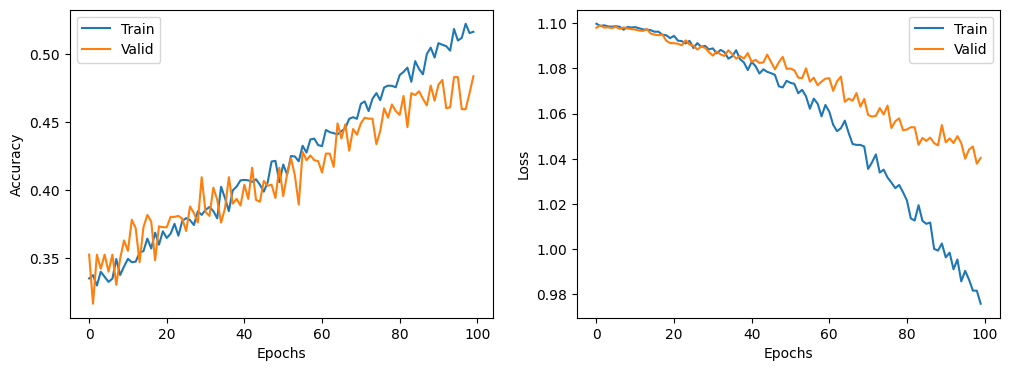

In [87]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train')
plt.plot(valid_acc, label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train')
plt.plot(valid_loss, label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')


In [78]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds = precision_recall_curve(test_labels, test_preds)
average_precision = average_precision_score(test_labels, test_preds)

plt.figure(figsize=(10, 8))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.plot(recall, precision)
plt.xlabel('Predicted Label', fontsize=15)
plt.ylabel('True Label', fontsize=15)

ValueError: multiclass format is not supported